In [1]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

if working_dir:
    os.chdir(working_dir)
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        if not os.path.exists(fast_local_dir):
            print("Creating fast local directory and extracting data...")
            os.makedirs(fast_local_dir, exist_ok=True)
            !unzip -q {zip_filename} -d {fast_local_dir}
        else:
            print("Dataset already exists in this Colab Session!")
    else:
        print(f"Error: {zip_filename} not found. Please run the Data Loading notebook first.")

Mounted at /content/drive
Working in MG folder: /content/drive/MyDrive/00gerem00/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.
Creating fast local directory and extracting data...


In [3]:
from torchvision.datasets import ImageFolder

base_dir = '/content/fast_dataset'

content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

print(f"Data path identified: {data_dir}")

dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Data path identified: /content/fast_dataset/Leather Defect Classification
Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [4]:
from PIL import Image

dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


# **2. Data Preprocessing & DataLoader**

First of all, to prepare the dataset for training we decide to split it in train, validation and test set. We opted for a standard 70, 15, 15 split ratio. Specifically, 70% of the data is allocated to the training set. The remaining 30% is divided equally between the validation and test sets. The validation set is actively used at the end of each epoch to monitor the model's generalization capabilities and prevent overfitting, while the test set is kept strictly isolated until the very end. This ensures an completely unbiased final evaluation of the model's accuracy.

In [8]:
import torch
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Completed split: {len(train_set)} training set, {len(val_set)} validation set, {len(test_set)} test set")

Completed split: 2518 training set, 540 validation set, 540 test set


Then we The `TransformSubset` Wrapper is used to apply preprocessing steps after the random dataset splitting. This ensures us to have each set applied the desired transormation without altering the underlying dataset structure.

In [15]:
from torchvision import transforms

class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

The goal of the training pipeline `train_transform` is **Data Augmentation** to artificially increase the diversity of the training set without collecting new data. In our leather defect classification task, it serves two main purposes:

1. **Increasing Variability:** It helps the model capture defects from multiple angles and under various lighting conditions, compensating for the fact that the images in our training set (2518) might not cover every real world scenario.
2. **Regularization and Preventing Overfitting:** By presenting a slightly different version of the same image in each epoch, we prevent the network from "memorizing" specific pixel patterns (noise). Instead, we force it to focus on robust, invariant structural and chromatic features of the defects (*folding marks, pinholes, etc.*).

These are the operations we applied:
* `transforms.Resize((230, 230))`: Starting from original $227 \times 227$ images, we upscale them to $230 \times 230$. Since it is impossible to create new data out of thin air, the system uses **Bilinear Interpolation**. The algorithm analyzes the original pixel grid and, as it "stretches" the image, fills the resulting gaps by calculating a weighted average of adjacent pixels.

* `transforms.RandomCrop((224, 224))`: We randomly cut out a $224 \times 224$ square from the $230 \times 230$ image. This teaches the model spatial invariance. Tt learns to recognize a defect whether it is perfectly in the center or slightly off to the edge.

* `transforms.RandomHorizontalFlip(p=0.5)`: There is a 50% probability the image will be flipped like a mirror. A scratch or a pinhole is still a defect regardless of whether it points left or right.

* `transforms.RandomRotation(15)`: We rotate the image by a random angle between -15 and +15 degrees. This simulates variations in how the camera or the leather might have been positioned on the factory line.

* `transforms.ColorJitter(brightness=0.15, contrast=0.12)`: This randomly alters the lighting. It prevents the model from relying on a specific factory lighting condition, making it robust against brighter or darker environments.
* `transforms.ToTensor()`: T It does not merely change the data type. It reshapes the raw image from a spatial format (Height $\times$ Width $\times$ Channels) with pixel intensities in the [0, 255] range, into a PyTorch compatible Tensor (Channels $\times$ Height $\times$ Width), scaling the values down to a [0.0, 1.0] float range for numerical stability.

* `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])`: It takes the [0.0, 1.0] tensor and applies normalization using a mean and standard deviation of $0.5$ across all three RGB channels.: $z = \frac{x_{c} - 0.5}{0.5}$ . This operation maps the data to an exact [-1.0, 1.0] range. The zero-centered distribution ensures numerical stability and faster gradient convergence during backpropagation.

Moreover, we apply training `mean` and `std` to both validation and test sets, since they must be normalized using the exact empirical mean and standard deviation computed exclusively from the training set. This ensures **Feature Space Consistency**: the neural network optimizes its weights based on the specific mathematical distribution of the training data; applying different normalization parameters to the test data would shift this distribution and invalidate the model's learned weights.


In [21]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.12),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_final = TransformSubset(train_set, transform=train_transform)
val_final = TransformSubset(val_set, transform=val_test_transform)
test_final = TransformSubset(test_set, transform=val_test_transform)

`DataLoaders` are created, which are essential tools for optimizing the data flow to the neural network. These components manage mini-batching by grouping images into blocks of 32 samples, obtaining gradient stability and computational efficiency.

The shuffle feature is enabled exclusively for the training set, reordering the images at each epoch to prevent the model from memorizing sequences and forcing it to recognize the actual visual patterns of leather defects. Conversely, validation and test data are loaded deterministically and sequentially, ensuring a rigorous evaluation and the accurate generation of the final confusion matrix through data unaltered by stochastic processes.

In [22]:
batch_size = 32

train_loader = DataLoader(
    train_final,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_final,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_final,
    batch_size=batch_size,
    shuffle=False
)

To verify the effectiveness of our preprocessing pipeline, we visualized a selection of images before and after applying data augmentation. By comparing the raw leather surfaces with their transformed counterparts, we can observe the impact of the rotation, scaling, and color jittering operations.

This step serves as a visual sanity check to ensure that the transformations introduce sufficient variability to prevent overfitting while preserving the distinctive features of each defect class.

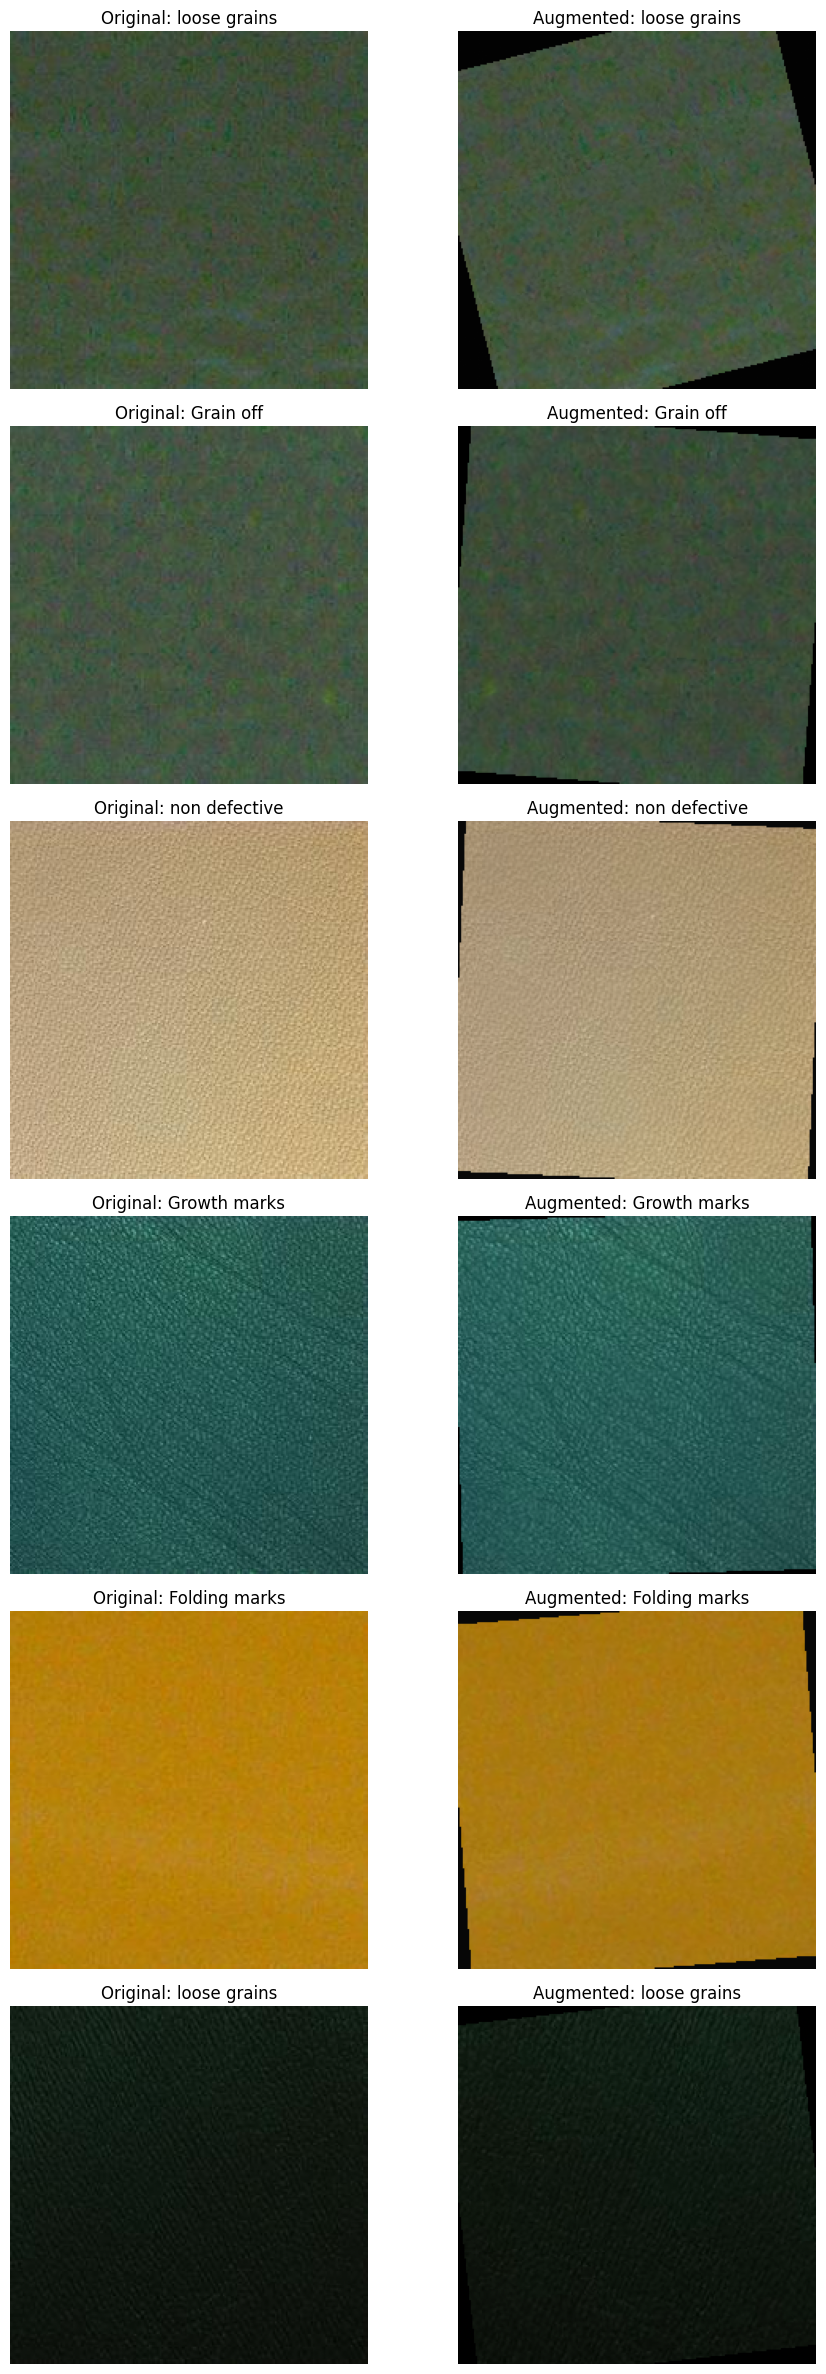

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_images = 6
random_indices = random.sample(range(len(train_final)), num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))
fig.suptitle("", fontsize=16)

for i, idx in enumerate(random_indices):
    orig_img, label_idx = train_final.subset[idx]
    aug_tensor, _ = train_final[idx]

    aug_img = aug_tensor / 2 + 0.5
    aug_np = aug_img.numpy()
    aug_np = np.transpose(aug_np, (1, 2, 0))

    label_name = dataset.classes[label_idx]

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {label_name}", fontsize=12)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(aug_np)
    axes[i, 1].set_title(f"Augmented: {label_name}", fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# **Model A: Custom ResNet-18**

In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        # Se cambiamo dimensione (stride != 1) o numero di canali, dobbiamo
        # adattare anche la "scorciatoia" con una convoluzione 1x1 per poter fare la somma finale
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x) # Salviamo l'input (o la sua versione adattata)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # IL CUORE DELLA RESNET: Sommiamo l'input all'output prima della ReLU finale
        out += identity
        out = self.relu(out)
        return out

import torch
import torch.nn as nn

# ==========================================
# 2. L'ARCHITETTURA: RESNET-18 (Senza MaxPool)
# ==========================================
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.in_channels = 64

        # --- STRATO INIZIALE ---
        # Accetta immagini RGB (3 canali)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ❌ RIMOSSO: self.maxpool = nn.MaxPool2d(...)

        # --- I 4 STRATI DI BLOCCHI RESIDUI ---
        self.layer1 = self._make_layer(64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)

        # --- CLASSIFICATORE FINALE ---
        # L'AdaptiveAvgPool è magico: non gli importa se in ingresso arrivano
        # tensori 7x7 o 14x14, li schiaccerà sempre e comunque a 1x1.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Passaggio iniziale
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # ❌ RIMOSSO: x = self.maxpool(x)

        # Passaggio nei blocchi residui
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classificazione
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x